In [117]:
from operator import index

import pandas as pd
import yfinance as yf
import numpy as np
from hurst import compute_Hc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from src import (data_loader, processing, feature_engineering, clustering)
from src.clustering import core

In [118]:
df = data_loader.download_raw_data(start_date='2000-01-01', end_date='2025-12-31')
df_processed = processing.prepare_market_data(df)
df_with_features = feature_engineering.add_spx_vix_features(df_processed)

C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [119]:
features = core.DEFAULT_FEATURE_COLS
df_features = core.build_feature_matrix(df_with_features, features)
x_scaled, scaler = core.scale_features(df_features[0])

In [120]:
X_pca_reduced, n_components, pca = core.pca_analysis(x_scaled, variance_target=0.9)

labels, kmeans_model = core.fit_kmeans(X_pca_reduced, n_clusters=2 , random_state=42)

In [121]:
df_assigned = core.assign_cluster_labels(df_with_features, df_features[1], labels, "KMeans_Regime")
df_assigned['KMeans_Regime'].value_counts()

KMeans_Regime
1    4689
0    1327
Name: count, dtype: Int64

In [122]:
df_assigned["target_regime"] = df_assigned["KMeans_Regime"].shift(-1)

#Drop rows where target or features are missing
supervised_cols = core.DEFAULT_FEATURE_COLS + ["target_regime"]
df_sup = df_assigned[supervised_cols].dropna().copy()

X_all = df_sup[core.DEFAULT_FEATURE_COLS]
y_all = df_sup["target_regime"].astype(int)

print(X_all.shape, y_all.value_counts())
df_sup.head()

(6015, 31) target_regime
1    4688
0    1327
Name: count, dtype: int64


,log_daily_return,20d_return,5d_volatility,20d_volatility,60d_volatility,vol_of_vol_20d,realized_quarticity_20d,realized_skew_20d,realized_kurtosis_20d,return_Zscore_20d,...,VRP_Proxy,corr_ret_dVIX_20d,ret_x_VIX,vol_x_VIX,vol_ratio,VIX_Zscore_X_DD,RSI_20,hurst_100d,ADX_14,target_regime
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-04,0.006194,0.001846,0.008010,0.008008,0.010520,0.000755,8.839692e-09,-0.846122,-0.386173,0.761978,...,0.025661,-0.855452,-0.000264,-0.000341,0.621609,0.116150,50.718383,0.633126,12.069354,1
2002-01-07,-0.006520,-0.001894,0.008952,0.008121,0.010205,0.000883,8.927064e-09,-0.763375,-0.619300,-0.791178,...,0.031516,-0.853087,-0.000459,0.000571,0.587603,-0.231473,49.285773,0.617571,12.169896,1
2002-01-08,-0.003595,0.002072,0.006821,0.007976,0.010060,0.001001,8.772094e-09,-0.845555,-0.355538,-0.463652,...,0.031622,-0.873921,0.000018,-0.000040,0.580040,0.004334,50.799434,0.626602,12.863343,1
2002-01-09,-0.004810,0.013343,0.007078,0.007136,0.010055,0.001160,5.526001e-09,-0.790284,-0.169147,-0.766938,...,0.036140,-0.843029,-0.000066,0.000097,0.511901,-0.075668,55.539353,0.621355,13.110975,1
2002-01-10,0.001220,0.017409,0.005175,0.007090,0.010050,0.001276,5.523104e-09,-0.893104,0.032773,0.050342,...,0.037328,-0.847678,0.000013,0.000073,0.503385,-0.059004,57.300979,0.629307,13.580086,1


In [123]:
def make_time_mask(df, start, end):
    return (df.index >= start) & (df.index <= end)

# split 1
mask_train1 = make_time_mask(df_sup, "2010-01-01", "2020-12-31")
mask_test1  = make_time_mask(df_sup, "2021-01-01", "2024-12-31")

# split 2
mask_train2 = make_time_mask(df_sup, "2003-01-01", "2015-12-31")
mask_test2  = make_time_mask(df_sup, "2016-01-01", "2020-12-31")

#creating the splits
splits = {
    "2010-20 → 2021-24": (mask_train1, mask_test1),
    "2003-15 → 2016-20": (mask_train2, mask_test2),
}


In [124]:
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs",
            penalty="l2",
        )),
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1,
    ),
    "GradientBoosting": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(
            random_state=42,
        )),
    ]),
}

In [125]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)
def evaluate_binary(y_true, y_prob, y_pred):
    """Compute a set of useful binary classification metrics."""
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["balanced_accuracy"] = balanced_accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)
    # y_prob = prob of class 1 (stressed regime)
    metrics["roc_auc"] = roc_auc_score(y_true, y_prob)
    return metrics

In [126]:
results = []
all_preds = []

for split_name, (mask_tr, mask_te) in splits.items():
    X_train, y_train = X_all[mask_tr], y_all[mask_tr]
    X_test,  y_test  = X_all[mask_te], y_all[mask_te]

    print(f"\n=== Split: {split_name} ===")
    print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])

    for model_name, model in models.items():
        # Fit
        model.fit(X_train, y_train)

        # Predict labels
        y_pred = model.predict(X_test)

        # Predict probabilities for class 1
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            # Try to access classifier inside a Pipeline
            clf = getattr(model, "named_steps", {}).get("clf", None)
            if clf is not None and hasattr(clf, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
            else:
                # fallback to decision_function + logistic
                dec = model.decision_function(X_test)
                y_prob = 1 / (1 + np.exp(-dec))

        # Metrics
        metrics = evaluate_binary(y_test, y_prob, y_pred)
        metrics.update({"split": split_name, "model": model_name})
        results.append(metrics)

        print(
            f"{model_name} → acc={metrics['accuracy']:.3f}, "
            f"bal_acc={metrics['balanced_accuracy']:.3f}, "
            f"f1={metrics['f1']:.3f}, auc={metrics['roc_auc']:.3f}"
        )

        # Store detailed predictions (for later analysis/trading)
        all_preds.append(pd.DataFrame({
            "split": split_name,
            "model": model_name,
            "date": df_sup.index[mask_te],
            "y_true": y_test,
            "y_pred": y_pred,
            "y_prob": y_prob,
        }))

results_df = pd.DataFrame(results)
preds_df = pd.concat(all_preds, ignore_index=True)

print("\nSummary results:")
display(results_df)



=== Split: 2010-20 → 2021-24 ===
Train size: 2769 | Test size: 1005
LogisticRegression → acc=0.957, bal_acc=0.964, f1=0.972, auc=0.996
RandomForest → acc=0.944, bal_acc=0.892, f1=0.965, auc=0.989
GradientBoosting → acc=0.940, bal_acc=0.874, f1=0.963, auc=0.991

=== Split: 2003-15 → 2016-20 ===
Train size: 3273 | Test size: 1259
LogisticRegression → acc=0.963, bal_acc=0.956, f1=0.977, auc=0.991
RandomForest → acc=0.940, bal_acc=0.931, f1=0.963, auc=0.987
GradientBoosting → acc=0.949, bal_acc=0.925, f1=0.969, auc=0.980

Summary results:


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,split,model
0,0.957214,0.964169,0.993447,0.952261,0.972418,0.995822,2010-20 → 2021-24,LogisticRegression
1,0.944279,0.892492,0.950122,0.981156,0.965389,0.989174,2010-20 → 2021-24,RandomForest
2,0.940299,0.874101,0.940191,0.987437,0.963235,0.991077,2010-20 → 2021-24,GradientBoosting
3,0.963463,0.956329,0.987039,0.967742,0.977295,0.991252,2003-15 → 2016-20,LogisticRegression
4,0.940429,0.930745,0.979757,0.946237,0.962705,0.986853,2003-15 → 2016-20,RandomForest
5,0.949166,0.924713,0.973346,0.963832,0.968566,0.980263,2003-15 → 2016-20,GradientBoosting


In [127]:
log_reg = models["LogisticRegression"]

def get_logreg_coeffs(model, feature_names):
    """Return a sorted dataframe of LR coefficients."""
    # model is a Pipeline: scaler + clf
    clf = model.named_steps["clf"]
    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
    }).sort_values("coef")
    return coef_df

logreg_coefs = get_logreg_coeffs(log_reg, core.DEFAULT_FEATURE_COLS)
logreg_coefs

,feature,coef
21,realized_vol_20d_ann,-2.383093
3,20d_volatility,-2.383093
15,downside_dev_20d,-2.104042
4,60d_volatility,-1.758360
20,VIX_vol_20d,-1.491162
2,5d_volatility,-0.830279
6,realized_quarticity_20d,-0.598472
22,VRP_Proxy,-0.510606
26,vol_ratio,-0.407150
5,vol_of_vol_20d,-0.404396



Random Forest feature importance:


,feature,importance
15,downside_dev_20d,0.193584
21,realized_vol_20d_ann,0.171135
3,20d_volatility,0.158144
6,realized_quarticity_20d,0.138699
13,current_drawdown,0.086369
4,60d_volatility,0.062994
2,5d_volatility,0.031210
11,slope_MA_50,0.021450
14,max_drawdown_252d,0.020698
10,slope_MA_20,0.020049



Gradient Boosting feature importance:


,feature,importance
15,downside_dev_20d,0.852805
13,current_drawdown,0.038612
6,realized_quarticity_20d,0.017809
3,20d_volatility,0.016898
21,realized_vol_20d_ann,0.012530
2,5d_volatility,0.010088
7,realized_skew_20d,0.008693
28,RSI_20,0.006676
5,vol_of_vol_20d,0.005354
11,slope_MA_50,0.004405



Confusion matrix (counts):
 [[204   5]
 [ 38 758]]

Confusion matrix (row-normalized):
 [[0.97607656 0.02392344]
 [0.04773869 0.95226131]]

True transition probabilities P(Regime_{t+1} | Regime_t):


Regime_next,0,1
KMeans_Regime,,
0,0.951017,0.048983
1,0.013865,0.986135



Predicted transition probabilities P(pred_{t+1} | pred_t):


Regime_pred_next,0.0,1.0
y_pred,,
0,0.954545,0.045455
1,0.014436,0.985564


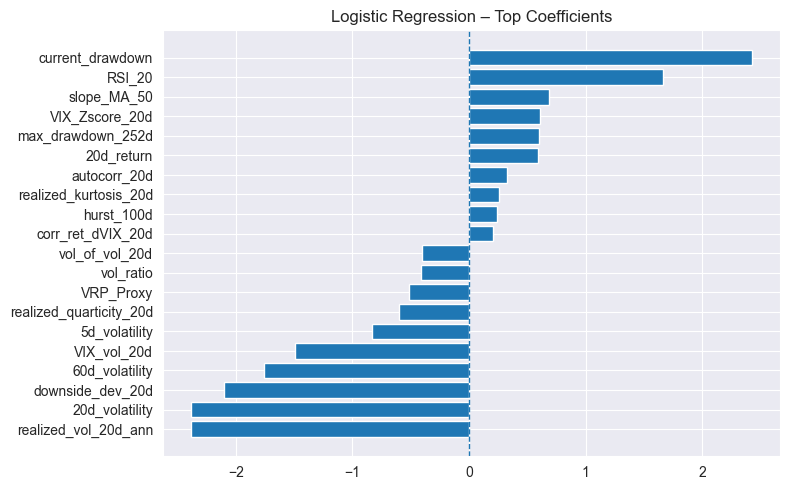

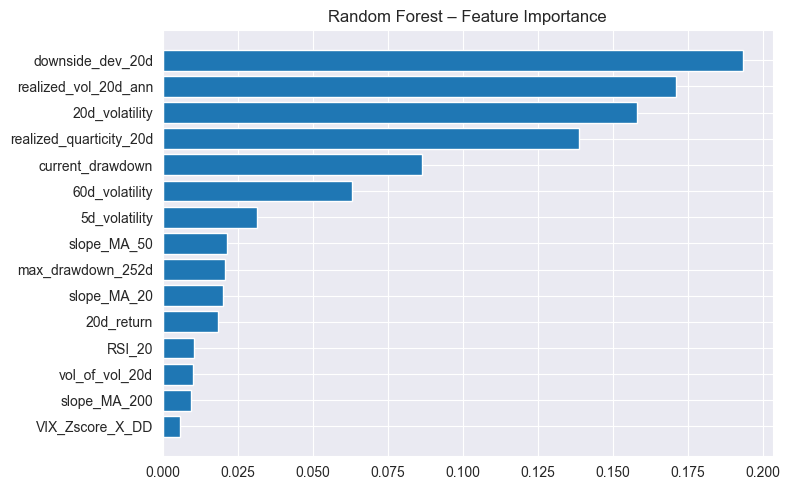

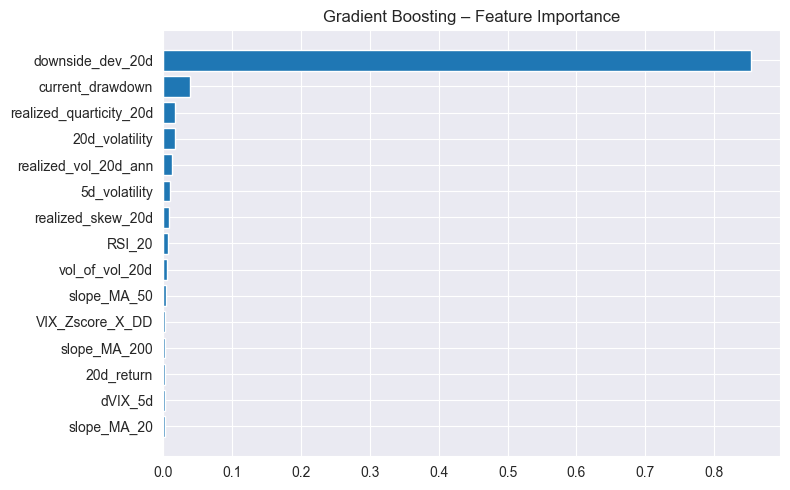

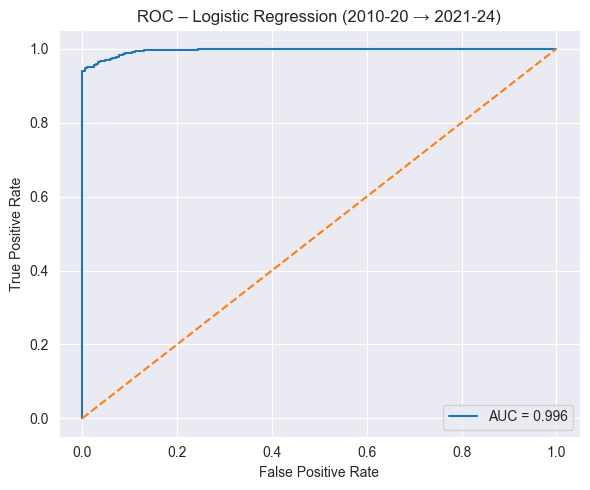

In [358]:
def plot_top_logreg_coefs(coef_df, n=10):
    top = pd.concat([coef_df.head(n), coef_df.tail(n)])
    top = top.sort_values("coef")
    plt.figure(figsize=(8, 5))
    plt.barh(top["feature"], top["coef"])
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.title("Logistic Regression – Top Coefficients")
    plt.tight_layout()

plot_top_logreg_coefs(logreg_coefs, n=10)


# Random Forest & Gradient Boosting feature importance
rf = models["RandomForest"]
gb = models["GradientBoosting"].named_steps["clf"]

def get_feature_importance(model, feature_names):
    imp = model.feature_importances_
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": imp,
    }).sort_values("importance", ascending=False)
    return df_imp

rf_imp = get_feature_importance(rf, core.DEFAULT_FEATURE_COLS)
gb_imp = get_feature_importance(gb, core.DEFAULT_FEATURE_COLS)

print("\nRandom Forest feature importance:")
display(rf_imp.head(15))
print("\nGradient Boosting feature importance:")
display(gb_imp.head(15))

def plot_feature_importance(imp_df, title, top=15):
    top_df = imp_df.head(top)[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(top_df["feature"], top_df["importance"])
    plt.title(title)
    plt.tight_layout()

plot_feature_importance(rf_imp, "Random Forest – Feature Importance")
plot_feature_importance(gb_imp, "Gradient Boosting – Feature Importance")


# ============================================================
# 6. Confusion matrix & ROC for a chosen split/model
#    (example: Logistic Regression, 2010-20 → 2021-24)
# ============================================================

mask_lr = (
    (preds_df["split"] == "2010-20 → 2021-24") &
    (preds_df["model"] == "LogisticRegression")
)
sub_lr = preds_df[mask_lr].copy().sort_values("date")

cm = confusion_matrix(sub_lr["y_true"], sub_lr["y_pred"])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

print("\nConfusion matrix (counts):\n", cm)
print("\nConfusion matrix (row-normalized):\n", cm_norm)

# ROC curve
fpr, tpr, _ = roc_curve(sub_lr["y_true"], sub_lr["y_prob"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Logistic Regression (2010-20 → 2021-24)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()


# ============================================================
# 7. Regime transition probabilities
# ============================================================

# 7.1 True transitions from original KMeans_Regime
df_trans = df_assigned[["KMeans_Regime"]].copy()
df_trans["Regime_next"] = df_trans["KMeans_Regime"].shift(-1)
df_trans = df_trans.dropna(subset=["KMeans_Regime", "Regime_next"])

true_trans = pd.crosstab(
    df_trans["KMeans_Regime"],
    df_trans["Regime_next"],
    normalize="index"
)
print("\nTrue transition probabilities P(Regime_{t+1} | Regime_t):")
display(true_trans)

# 7.2 Predicted transitions (same LR split as above)
sub_lr["Regime_pred_next"] = sub_lr["y_pred"].shift(-1)
sub_lr_trans = sub_lr.dropna(subset=["y_pred", "Regime_pred_next"])

pred_trans = pd.crosstab(
    sub_lr_trans["y_pred"],
    sub_lr_trans["Regime_pred_next"],
    normalize="index"
)
print("\nPredicted transition probabilities P(pred_{t+1} | pred_t):")
display(pred_trans)
